In [2]:
%load_ext iminizinc
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import datetime
from z3 import *

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.4.3, build 122680178
Copyright (C) 2014-2020 Monash University, NICTA, Data61


<b> <h2> ACCESSORY FUNCTIONS </h2> </b>

In [5]:
def read_instance(path):
    file = open(path,"r").readlines()
    pr_w , pr_h = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n_pieces = int(file[1].rstrip("\n"))
    L = []
    for i in range(2, n_pieces + 2):
        L.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return pr_w, pr_h, n_pieces, L

In [6]:
def order_pieces(pieces, reverse=False):
    areas = [p[0] * p[1] for p in pieces]
    sorted_indices = sorted(range(len(areas)), key=lambda k: areas[k], reverse=reverse)
    ordered_pieces = [pieces[i] for i in sorted_indices]
    return ordered_pieces

In [7]:
PRINT_FIRST_N_SOL = 100
PRINT_LAST_N_SOL = 100
PRINT_EVERY_N_SOL = 10000

def graph_solution(pr_w, pr_h, n_pieces, pieces, q, colours=None):
    if colours is None:
        colours = np.random.rand(n_pieces, 3)
    fig, ax = plt.subplots()
    for i in range(n_pieces):
        ax.add_patch(patches.Rectangle(
            q[i],
            pieces[i][0],
            pieces[i][1],
            facecolor=colours[i]
        ))
    ax.axis("equal")
    ax.xaxis.set_ticks(np.arange(0, pr_w+2, 2))
    ax.set_xlim(0, pr_w)
    ax.yaxis.set_ticks(np.arange(0, pr_h+2, 2))
    ax.set_ylim(0, pr_h)
    plt.show()
    print(f"Solution: {q}")
    print(f"[w, h]:   {pieces}\n")

    
def update_dim_based_on_rot(l, rot):
    c = []
    for i, r in enumerate(rot):
        if r == 1: #I have to invert the i-th value of l
            c.append([l[i][1], l[i][0]])
        else:
            c.append([l[i][0], l[i][1]])

    return c
    
"""
Print the first PRINT_FIRST_N_SOL, the last PRINT_LAST_N_SOL solutions and in between every PRINT_EVERY_N_SOL solutions.
"""
def print_solutions(res, instance_info):
    n_sol = len(res)
    colours = np.random.rand(instance_info['n'], 3)
    if not isinstance(res, list):
        n_sol = 1
        print("coords:   {}".format(res["q"]))
        dim = instance_info['p']
        if 'rot' in res: #I manage the printing with rotation   0:no rotation, 1:yes rotation
            print("rotation: {}".format(res["rot"]))
            dim = update_dim_based_on_rot(dim, res["rot"])
            
        graph_solution(instance_info['w'], instance_info['h'], instance_info['n'], dim, res["q"], colours)
    else:
        last_i = 0
        for i, x in enumerate(res):
            dim = []
            if i < PRINT_FIRST_N_SOL or i >= (n_sol-PRINT_LAST_N_SOL) or ((i+1)%PRINT_EVERY_N_SOL == 0):
                if i > last_i+1:
                    print(" ... ")
                print("{} : {} ".format(i, x['q']))
                
                dim = instance_info['p']
                if 'rot' in x: #I manage the printing with rotation   0:no rotation, 1:yes rotation
                    print("rotation: {}".format(x["rot"]))
                    dim = update_dim_based_on_rot(dim, x["rot"])
                
                graph_solution(instance_info['w'], instance_info['h'], instance_info['n'], dim, x["q"], colours)
                last_i = i
                
                

    print("Tot: {}\n".format(n_sol))

<b> <h2> INPUT </h2> </b>

In [6]:
model_name = "pwp_v7.mzn"
instance_name = "8x8" #change here the instance

<b> TEST 1 </b> (see report) <br>
change instance_name manually <br>
no-ord $\;\;$  => comment line "L = order_pieces..." <br>
ord $\;\;\;\;\;\;$     => decr_order = <u>False</u> and apply ordering <br>
decr-ord => decr_order = <u>True</u> and apply ordering

<b> TEST 2 </b> (see report) <br>
change instance_name manually <br>
ord $\;\;\;\;\;\;$     => decr_order = <u>False</u> and apply ordering <br>
decr-ord => decr_order = <u>True</u> and apply ordering <br>
comment/uncomment the relative search_ann row inside the model(pwp_v7.mzn)

%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=36
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.211958
mzn-stat-end
mzn-stat: initTime=0.02
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=42
mzn-stat: propagators=22
mzn-stat: propagations=92
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
coords:   [[0, 0], [5, 0], [3, 5], [0, 5]]


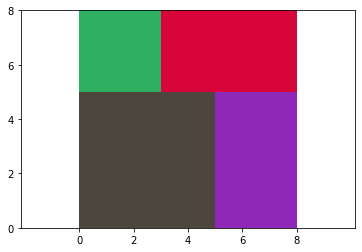

Solution: [[0, 0], [5, 0], [3, 5], [0, 5]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

Tot: 1



{'q': [[0, 0], [5, 0], [3, 5], [0, 5]]}

In [14]:
path = f"CP/src/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -s CP/$model_name -t 6000

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})
solutions

<b> TEST 3 </b> (see report) <br>
comment/uncomment the relative search_ann row inside the model(pwp_v7.mzn)

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=13
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=14
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.161824
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=38
mzn-stat: propagators=12
mzn-stat: propagations=36
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end


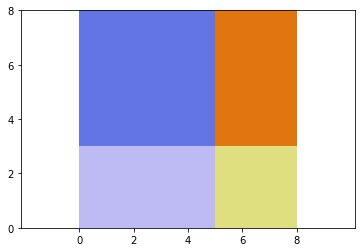

Solution: [[5, 0], [5, 3], [0, 0], [0, 3]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]



|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=20
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=53
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.159252
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=64
mzn-stat: propagators=51
mzn-stat: propagations=154
mzn-stat: nodes=6
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


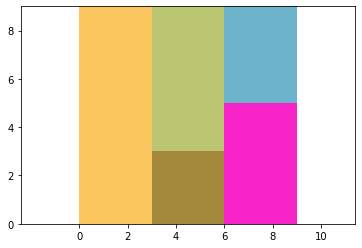

Solution: [[3, 0], [6, 5], [6, 0], [3, 3], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



|| === Instance 10x10 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=58
mzn-stat: flatIntVars=23
mzn-stat: flatBoolConstraints=15
mzn-stat: flatIntConstraints=74
mzn-stat: evaluatedHalfReifiedConstraints=58
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.160131
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=92
mzn-stat: propagators=59
mzn-stat: propagations=174
mzn-stat: nodes=6
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


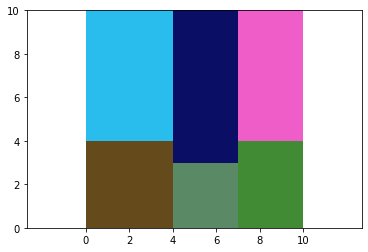

Solution: [[4, 0], [7, 0], [7, 4], [4, 3], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

Pieces: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]



|| === Instance 11x11 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=84
mzn-stat: flatIntVars=30
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=102
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.190785
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=114
mzn-stat: propagators=107
mzn-stat: propagations=1070
mzn-stat: nodes=20
mzn-stat: failures=5
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


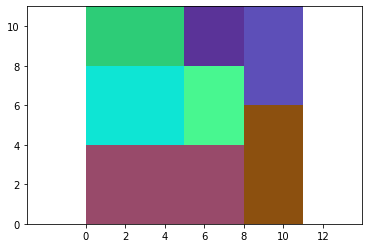

Solution: [[5, 8], [5, 4], [8, 6], [8, 0], [0, 8], [0, 4], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]



|| === Instance 12x12 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=112
mzn-stat: flatIntVars=34
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=132
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.16544
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=146
mzn-stat: propagators=139
mzn-stat: propagations=2397
mzn-stat: nodes=37
mzn-stat: failures=14
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


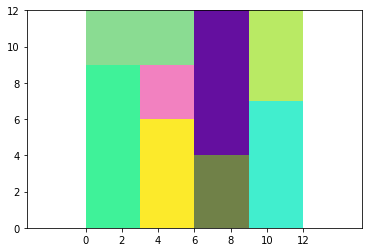

Solution: [[3, 6], [6, 0], [9, 7], [3, 0], [9, 0], [6, 4], [0, 0], [0, 9]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]



|| === Instance 13x13 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=144
mzn-stat: flatIntVars=38
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=166
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.170056
mzn-stat-end
mzn-stat: initTime=0.014
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=182
mzn-stat: propagators=189
mzn-stat: propagations=1089
mzn-stat: nodes=15
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


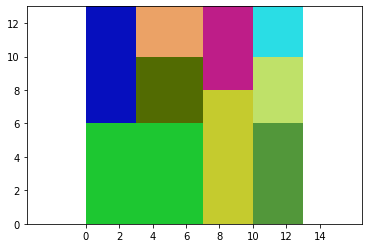

Solution: [[10, 10], [10, 6], [7, 8], [10, 0], [0, 6], [7, 0], [3, 10], [3, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]



|| === Instance 14x14 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=35
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=164
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.177815
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=188
mzn-stat: propagators=148
mzn-stat: propagations=460
mzn-stat: nodes=10
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=9
mzn-stat-end


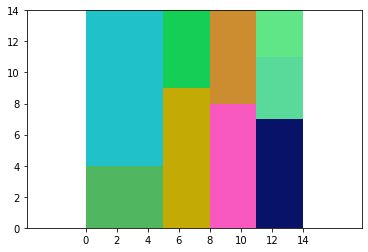

Solution: [[11, 11], [11, 7], [5, 9], [8, 8], [11, 0], [8, 0], [5, 0], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]



|| === Instance 15x15 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=40
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=203
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.171658
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=224
mzn-stat: propagators=214
mzn-stat: propagations=772
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


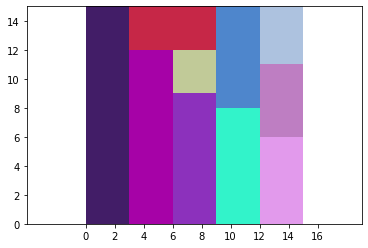

Solution: [[6, 9], [12, 11], [12, 6], [12, 0], [9, 8], [9, 0], [6, 0], [3, 0], [0, 0], [3, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]



|| === Instance 16x16 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=204
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.171858
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=222
mzn-stat: propagators=220
mzn-stat: propagations=811
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


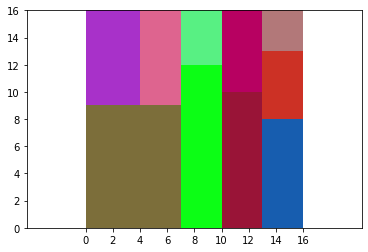

Solution: [[13, 13], [7, 12], [13, 8], [10, 10], [4, 9], [13, 0], [10, 0], [7, 0], [0, 9], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]



|| === Instance 17x17 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=264
mzn-stat: flatIntVars=50
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=292
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.175224
mzn-stat-end
mzn-stat: initTime=0.018
mzn-stat: solveTime=0.004
mzn-stat: solutions=1
mzn-stat: variables=314
mzn-stat: propagators=335
mzn-stat: propagations=26843
mzn-stat: nodes=273
mzn-stat: failures=129
mzn-stat: restarts=0
mzn-stat: peakDepth=20
mzn-stat-end


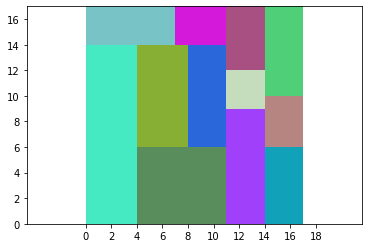

Solution: [[11, 9], [14, 6], [11, 12], [14, 0], [14, 10], [8, 6], [11, 0], [7, 14], [4, 6], [0, 0], [0, 14], [4, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]



|| === Instance 18x18 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=392
mzn-stat: flatIntVars=57
mzn-stat: flatBoolConstraints=104
mzn-stat: flatIntConstraints=423
mzn-stat: evaluatedHalfReifiedConstraints=392
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.186853
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=490
mzn-stat: propagators=393
mzn-stat: propagations=1182
mzn-stat: nodes=16
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end


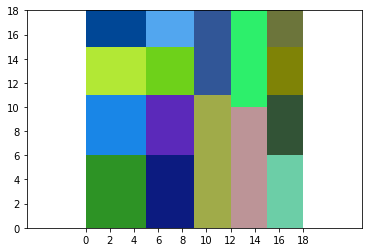

Solution: [[15, 15], [15, 11], [15, 6], [15, 0], [9, 11], [12, 10], [12, 0], [9, 0], [5, 15], [5, 11], [5, 6], [5, 0], [0, 15], [0, 11], [0, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]



|| === Instance 19x19 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=358
mzn-stat: flatIntVars=52
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=388
mzn-stat: evaluatedHalfReifiedConstraints=358
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.192508
mzn-stat-end
mzn-stat: initTime=0.022
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=430
mzn-stat: propagators=366
mzn-stat: propagations=1239
mzn-stat: nodes=16
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-

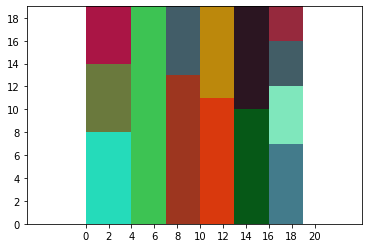

Solution: [[16, 16], [16, 12], [16, 7], [7, 13], [16, 0], [10, 11], [13, 10], [13, 0], [10, 0], [7, 0], [4, 0], [0, 14], [0, 8], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]



|| === Instance 20x20 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=364
mzn-stat: flatIntVars=58
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=398
mzn-stat: evaluatedHalfReifiedConstraints=364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.232385
mzn-stat-end
mzn-stat: initTime=0.028
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=422
mzn-stat: propagators=348
mzn-stat: propagations=2094
mzn-stat: nodes=32
mzn-stat: failures=7
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end


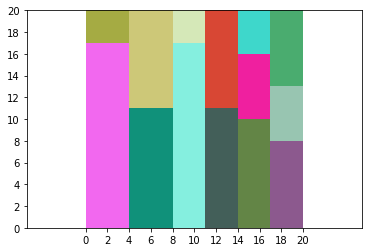

Solution: [[8, 17], [14, 16], [17, 8], [14, 10], [17, 13], [17, 0], [11, 11], [14, 0], [11, 0], [8, 0], [0, 17], [4, 11], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]



|| === Instance 21x21 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=388
mzn-stat: flatIntVars=56
mzn-stat: flatBoolConstraints=99
mzn-stat: flatIntConstraints=420
mzn-stat: evaluatedHalfReifiedConstraints=388
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.231461
mzn-stat-end
mzn-stat: initTime=0.029
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=470
mzn-stat: propagators=362
mzn-stat: propagations=3955
mzn-stat: nodes=71
mzn-stat: failures=27
mzn-stat: restarts=0
mzn-stat: peakDepth=17
mzn-stat-end


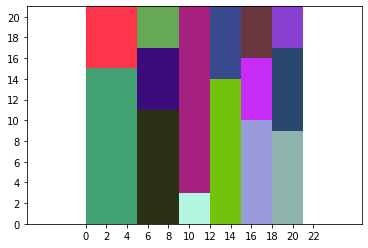

Solution: [[9, 0], [18, 17], [15, 16], [15, 10], [12, 14], [18, 9], [18, 0], [15, 0], [12, 0], [9, 3], [5, 17], [5, 11], [5, 0], [0, 15], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]



|| === Instance 22x22 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=480
mzn-stat: flatIntVars=64
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=515
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.240938
mzn-stat-end
mzn-stat: initTime=0.033
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=548
mzn-stat: propagators=561
mzn-stat: propagations=2244
mzn-stat: nodes=19
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDe

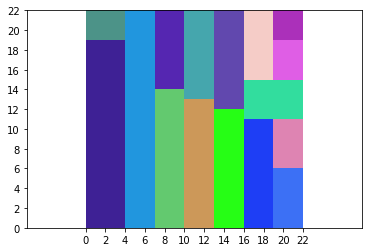

Solution: [[19, 19], [19, 15], [19, 6], [19, 0], [16, 15], [7, 14], [10, 13], [13, 12], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 19], [0, 0], [16, 11]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



|| === Instance 23x23 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=78
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=726
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.246665
mzn-stat-end
mzn-stat: initTime=0.042
mzn-stat: solveTime=13.266
mzn-stat: solutions=1
mzn-stat: variables=762
mzn-stat: propagators=850
mzn-stat: propagations=29586554
mzn-stat: nodes=597585
mzn-stat: failure

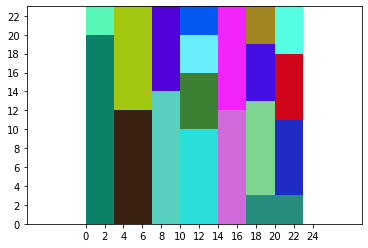

Solution: [[0, 20], [17, 19], [20, 18], [17, 13], [20, 11], [20, 3], [7, 14], [17, 3], [14, 12], [14, 0], [7, 0], [0, 0], [10, 20], [10, 16], [10, 10], [10, 0], [3, 12], [3, 0], [17, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]



|| === Instance 24x24 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=566
mzn-stat: flatIntVars=65
mzn-stat: flatBoolConstraints=145
mzn-stat: flatIntConstraints=602
mzn-stat: evaluatedHalfReifiedConstraints=566
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.235681
mzn-stat-end
mzn-stat: initTime=0.036
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=666
mzn-stat: propagator

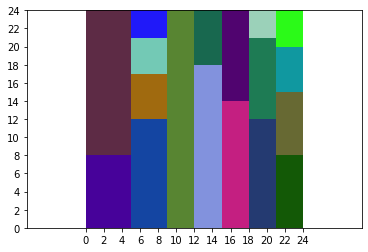

Solution: [[18, 21], [21, 20], [21, 15], [12, 18], [21, 8], [21, 0], [18, 12], [15, 14], [18, 0], [15, 0], [12, 0], [9, 0], [5, 21], [5, 17], [5, 12], [5, 0], [0, 0], [0, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]



|| === Instance 25x25 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=76
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=725
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.239935
mzn-stat-end
mzn-stat: initTime=0.041
mzn-stat: solveTime=0.164
mzn-stat: solutions=1
mzn-stat: variables=764
mzn-stat: propagators=804
mzn-stat: propagations=5

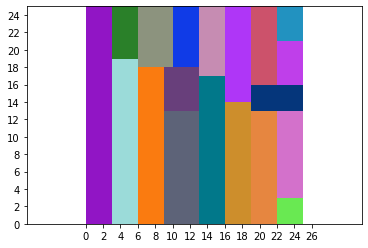

Solution: [[22, 0], [22, 21], [22, 16], [3, 19], [10, 18], [13, 17], [19, 16], [22, 3], [16, 14], [19, 0], [16, 0], [13, 0], [6, 0], [3, 0], [0, 0], [9, 13], [6, 18], [9, 0], [19, 13]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]



|| === Instance 26x26 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=90
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=974
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.283217
mzn-stat-end
mzn-stat: initTime=0.054
mzn-stat: solveTime=0.06
mzn-stat: solutions=1
mzn-stat: variables=1014
mzn-stat: propagator

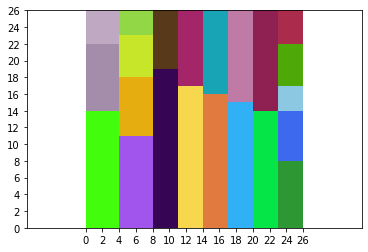

Solution: [[23, 14], [23, 22], [23, 17], [23, 8], [8, 19], [23, 0], [11, 17], [14, 16], [17, 15], [20, 14], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [4, 23], [0, 22], [4, 18], [4, 11], [0, 14], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]



|| === Instance 27x27 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=840
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstraints=210
mzn-stat: flatIntConstraints=888
mzn-stat: evaluatedHalfReifiedConstraints=840
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.254862
mzn-stat-end
mzn-stat: initTime=0.05
mzn-stat: solve

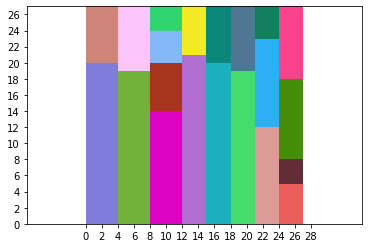

Solution: [[24, 5], [21, 23], [24, 0], [12, 21], [15, 20], [18, 19], [24, 18], [24, 8], [21, 12], [21, 0], [18, 0], [15, 0], [12, 0], [8, 24], [8, 20], [8, 14], [0, 20], [4, 19], [8, 0], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]



|| === Instance 28x28 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=918
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=966
mzn-stat: evaluatedHalfReifiedConstraints=918
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.259707
mzn-stat-end
mzn-stat: initTime=0.053
mzn-stat: solveTime=0.003
mzn-stat: soluti

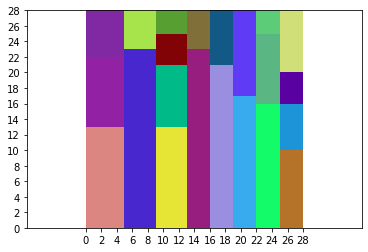

Solution: [[22, 25], [25, 16], [13, 23], [25, 10], [16, 21], [25, 20], [22, 16], [25, 0], [19, 17], [22, 0], [19, 0], [16, 0], [13, 0], [9, 25], [9, 21], [5, 23], [9, 13], [9, 0], [5, 0], [0, 22], [0, 13], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]



|| === Instance 29x29 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1098
mzn-stat: flatIntVars=94
mzn-stat: flatBoolConstraints=276
mzn-stat: flatIntConstraints=1150
mzn-stat: evaluatedHalfReifiedConstraints=1098
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.260223
mzn-stat-end
mzn-stat: initTime=0.059
mzn-stat: so

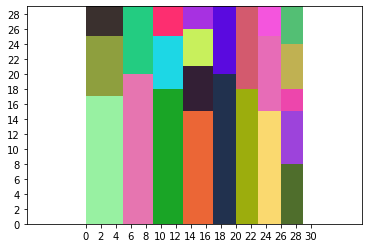

Solution: [[26, 15], [23, 25], [26, 24], [26, 18], [26, 8], [26, 0], [17, 20], [23, 15], [20, 18], [23, 0], [20, 0], [17, 0], [13, 26], [9, 25], [13, 21], [13, 15], [9, 18], [5, 20], [13, 0], [9, 0], [5, 0], [0, 25], [0, 17], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]



|| === Instance 30x30 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=720
mzn-stat: flatIntVars=73
mzn-stat: flatBoolConstraints=185
mzn-stat: flatIntConstraints=760
mzn-stat: evaluatedHalfReifiedConstraints=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.246688
m

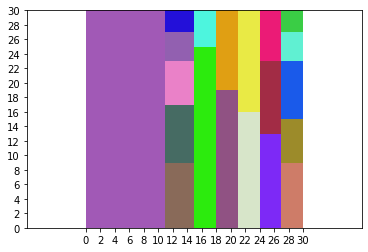

Solution: [[27, 27], [27, 23], [15, 25], [27, 9], [24, 23], [27, 15], [27, 0], [24, 13], [18, 19], [24, 0], [21, 16], [21, 0], [18, 0], [15, 0], [11, 27], [11, 23], [11, 17], [11, 9], [11, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]



|| === Instance 31x31 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=654
mzn-stat: flatIntVars=69
mzn-stat: flatBoolConstraints=167
mzn-stat: flatIntConstraints=692
mzn-stat: evaluatedHalfReifiedConstraints=654
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.239581
mzn-stat-end
mzn-stat: initTime=0.04
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: var

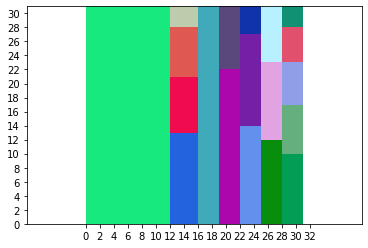

Solution: [[28, 28], [22, 27], [28, 23], [28, 17], [28, 10], [25, 23], [19, 22], [28, 0], [25, 12], [25, 0], [22, 14], [22, 0], [19, 0], [16, 0], [12, 28], [12, 21], [12, 13], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]



|| === Instance 32x32 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1404
mzn-stat: flatIntVars=110
mzn-stat: flatBoolConstraints=351
mzn-stat: flatIntConstraints=1464
mzn-stat: evaluatedHalfReifiedConstraints=1404
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.274907
mzn-stat-end
mzn-stat: initTime=0.078
mzn-stat: solveTime=0.003
mzn-stat: solutions=1
mzn-stat: variables=1514
mzn-s

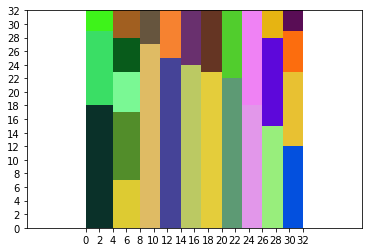

Solution: [[29, 29], [26, 28], [8, 27], [29, 23], [11, 25], [14, 24], [17, 23], [20, 22], [29, 12], [29, 0], [26, 15], [23, 18], [26, 0], [23, 0], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [0, 29], [4, 28], [4, 23], [4, 17], [4, 0], [4, 7], [0, 18], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]



|| === Instance 33x33 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1010
mzn-stat: flatIntVars=89
mzn-stat: flatBoolConstraints=253
mzn-stat: flatIntConstraints=1060
mzn-stat: eval

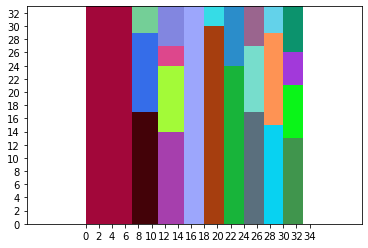

Solution: [[18, 30], [27, 29], [30, 21], [24, 27], [30, 26], [30, 13], [21, 24], [24, 17], [30, 0], [27, 15], [27, 0], [24, 0], [21, 0], [18, 0], [15, 0], [11, 24], [7, 29], [11, 27], [11, 14], [7, 17], [11, 0], [7, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]



|| === Instance 34x34 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=810
mzn-stat: flatIntVars=77
mzn-stat: flatBoolConstraints=206
mzn-stat: flatIntConstraints=852
mzn-stat: evaluatedHalfReifiedConstraints=810
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.256422
mzn-stat-end
mz

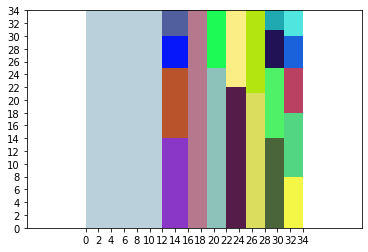

Solution: [[28, 31], [31, 30], [31, 25], [28, 25], [31, 18], [31, 0], [19, 25], [31, 8], [28, 14], [22, 22], [25, 21], [28, 0], [25, 0], [22, 0], [19, 0], [16, 0], [12, 30], [12, 25], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]



|| === Instance 35x35 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=973
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.2541
mzn-stat-end
mzn-stat: initTime=0.058
mzn-stat: solveTime=0.018
mz

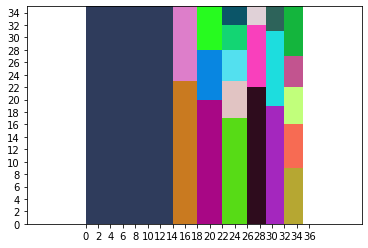

Solution: [[26, 32], [29, 31], [32, 22], [32, 16], [32, 9], [32, 27], [32, 0], [26, 22], [29, 19], [29, 0], [26, 0], [22, 32], [22, 28], [22, 23], [22, 17], [18, 28], [18, 20], [14, 23], [22, 0], [18, 0], [14, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]



|| === Instance 36x36 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=916
mzn-stat: flatIntVars=82
mzn-stat: flatBoolConstraints=234
mzn-stat: flatIntConstraints=960
mzn-stat: evaluatedHalfReifiedConstraints=916
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.263911
mzn-stat-end
mzn-stat: initTime=0.054
mzn-s

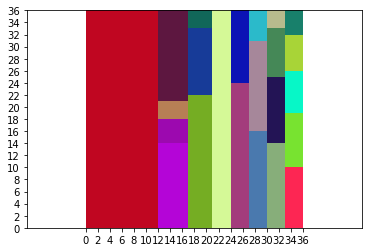

Solution: [[30, 33], [33, 32], [27, 31], [33, 26], [33, 19], [30, 25], [33, 10], [33, 0], [30, 14], [24, 24], [30, 0], [27, 16], [27, 0], [24, 0], [21, 0], [17, 33], [17, 22], [17, 0], [12, 18], [12, 14], [12, 0], [12, 21], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]



|| === Instance 37x37 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1364
mzn-stat: flatIntVars=101
mzn-stat: flatBoolConstraints=346
mzn-stat: flatIntConstraints=1419
mzn-stat: evaluatedHalfReifiedConstraints=1364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.277681
mzn-s

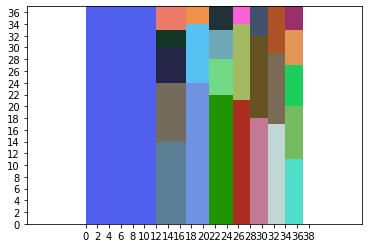

Solution: [[25, 34], [34, 33], [28, 32], [34, 27], [34, 20], [31, 29], [34, 11], [34, 0], [31, 17], [25, 21], [28, 18], [31, 0], [28, 0], [25, 0], [17, 34], [21, 33], [21, 28], [21, 22], [17, 24], [21, 0], [17, 0], [12, 30], [12, 33], [12, 24], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]



|| === Instance 38x38 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=74
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=727
mzn-st

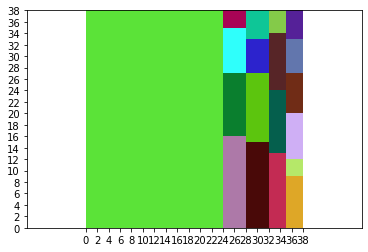

Solution: [[35, 9], [32, 34], [35, 33], [35, 27], [35, 20], [35, 12], [35, 0], [32, 24], [32, 13], [32, 0], [24, 35], [28, 33], [28, 27], [24, 27], [24, 16], [28, 15], [28, 0], [24, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]



|| === Instance 39x39 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1624
mzn-stat: flatIntVars=114
mzn-stat: flatBoolConstraints=406
mzn-stat: flatIntConstraints=1688
mzn-stat: evaluatedHalfReifiedConstraints=1624
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.297977
mzn-stat-end
mzn-stat: initTime=0.082
mzn-stat: solveTime=0.003
mzn-stat: solutions=1
mzn-stat: variables=1748
mzn-st

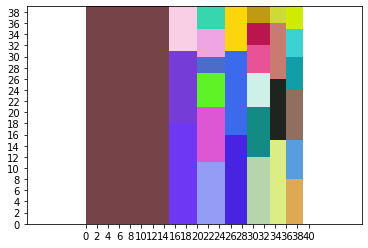

Solution: [[33, 36], [36, 35], [36, 30], [36, 24], [36, 8], [36, 0], [36, 15], [33, 26], [33, 15], [33, 0], [29, 36], [29, 32], [29, 27], [29, 21], [25, 31], [29, 12], [29, 0], [25, 16], [25, 0], [20, 27], [20, 35], [20, 30], [20, 21], [15, 31], [20, 11], [20, 0], [15, 18], [15, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]



|| === Instance 40x40 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=640
mzn-stat: flatIntVars=69
mzn-stat: flatBoolConstra

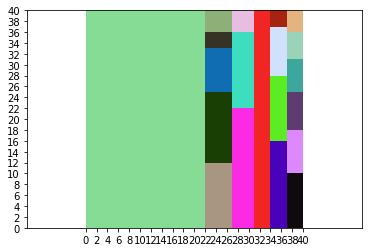

Solution: [[34, 37], [37, 36], [37, 31], [37, 25], [37, 18], [37, 10], [34, 28], [37, 0], [34, 16], [34, 0], [31, 0], [27, 36], [27, 22], [27, 0], [22, 33], [22, 36], [22, 25], [22, 0], [22, 12], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]





In [7]:
starting_instance = 8
ending_instance = 40

for i in range(starting_instance, ending_instance+1):
    path = f"CP/src/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    # execute the model to get the first solution in 5 min max
    sol = %minizinc -s CP/pwp_v9.mzn -t 300000
    
    if sol is not None:
        graph_solution(pr_w, pr_h, n_pieces, L, sol['q'])
    else:
        print("No solution found in 5min")
        
    print(f"Pieces: {L}")
    print("\n\n")

ROTATION

%%%mzn-stat: nSolutions=62
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=60
mzn-stat: flatIntVars=38
mzn-stat: flatBoolConstraints=15
mzn-stat: flatIntConstraints=94
mzn-stat: evaluatedHalfReifiedConstraints=60
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.156551
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0.01
mzn-stat: solutions=62
mzn-stat: variables=104
mzn-stat: propagators=119
mzn-stat: propagations=38210
mzn-stat: nodes=651
mzn-stat: failures=264
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end
0 : [[0, 0], [7, 3], [4, 0], [0, 6], [4, 6], [4, 3]] 
rotation: [0, 0, 1, 0, 0, 0]


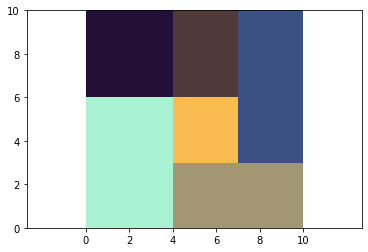

Solution: [[0, 0], [7, 3], [4, 0], [0, 6], [4, 6], [4, 3]]
[w, h]:   [[4, 6], [3, 7], [6, 3], [4, 4], [3, 4], [3, 3]]

1 : [[0, 0], [7, 3], [4, 0], [0, 6], [4, 3], [4, 7]] 
rotation: [0, 0, 1, 0, 0, 0]


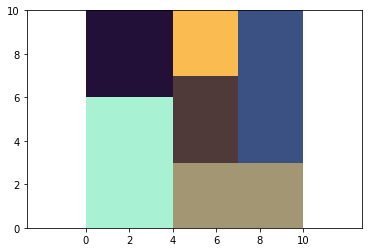

Solution: [[0, 0], [7, 3], [4, 0], [0, 6], [4, 3], [4, 7]]
[w, h]:   [[4, 6], [3, 7], [6, 3], [4, 4], [3, 4], [3, 3]]

2 : [[0, 0], [7, 0], [4, 7], [0, 6], [4, 3], [4, 0]] 
rotation: [0, 0, 1, 0, 0, 0]


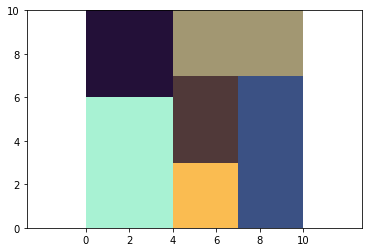

Solution: [[0, 0], [7, 0], [4, 7], [0, 6], [4, 3], [4, 0]]
[w, h]:   [[4, 6], [3, 7], [6, 3], [4, 4], [3, 4], [3, 3]]

3 : [[0, 0], [7, 0], [4, 7], [0, 6], [4, 0], [4, 4]] 
rotation: [0, 0, 1, 0, 0, 0]


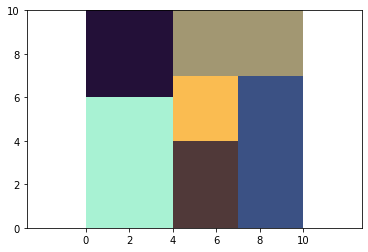

Solution: [[0, 0], [7, 0], [4, 7], [0, 6], [4, 0], [4, 4]]
[w, h]:   [[4, 6], [3, 7], [6, 3], [4, 4], [3, 4], [3, 3]]

4 : [[0, 0], [7, 3], [4, 4], [0, 6], [4, 0], [7, 0]] 
rotation: [0, 0, 0, 0, 0, 0]


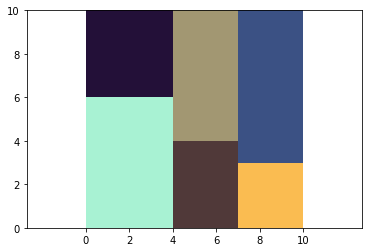

Solution: [[0, 0], [7, 3], [4, 4], [0, 6], [4, 0], [7, 0]]
[w, h]:   [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

 ... 
57 : [[3, 0], [7, 0], [0, 4], [3, 6], [0, 0], [7, 7]] 
rotation: [0, 0, 0, 0, 0, 0]


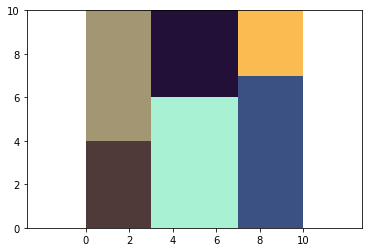

Solution: [[3, 0], [7, 0], [0, 4], [3, 6], [0, 0], [7, 7]]
[w, h]:   [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

58 : [[3, 0], [7, 3], [0, 0], [3, 6], [0, 6], [7, 0]] 
rotation: [0, 0, 0, 0, 0, 0]


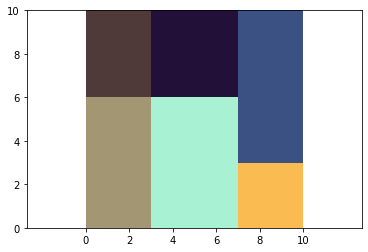

Solution: [[3, 0], [7, 3], [0, 0], [3, 6], [0, 6], [7, 0]]
[w, h]:   [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

59 : [[3, 0], [7, 0], [0, 0], [3, 6], [0, 6], [7, 7]] 
rotation: [0, 0, 0, 0, 0, 0]


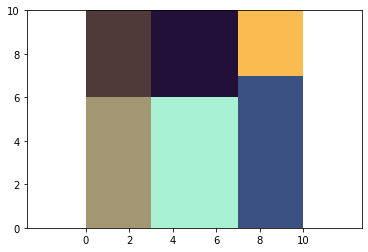

Solution: [[3, 0], [7, 0], [0, 0], [3, 6], [0, 6], [7, 7]]
[w, h]:   [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

60 : [[3, 0], [0, 3], [7, 0], [6, 6], [3, 6], [0, 0]] 
rotation: [0, 0, 0, 0, 0, 0]


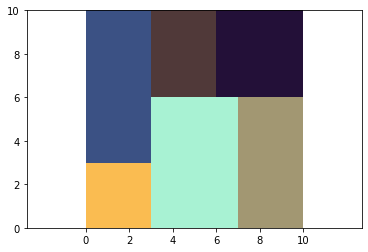

Solution: [[3, 0], [0, 3], [7, 0], [6, 6], [3, 6], [0, 0]]
[w, h]:   [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

61 : [[3, 0], [0, 0], [7, 0], [6, 6], [3, 6], [0, 7]] 
rotation: [0, 0, 0, 0, 0, 0]


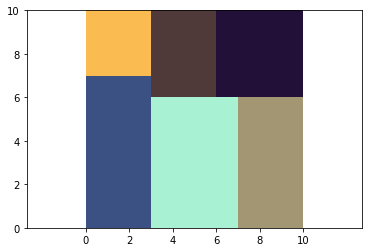

Solution: [[3, 0], [0, 0], [7, 0], [6, 6], [3, 6], [0, 7]]
[w, h]:   [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]

Tot: 62



In [12]:
model_name = "pwp_v7-rot"
instance_name = "10x10"

path = f"CP/src/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/pwp_v7-rot.mzn -t 300000

# Update L for each piece rotated

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=3
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=36
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.160903
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=3
mzn-stat: variables=42
mzn-stat: propagators=22
mzn-stat: propagations=162
mzn-stat: nodes=7
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
0 : [[0, 0], [5, 3], [0, 5], [5, 0]] 


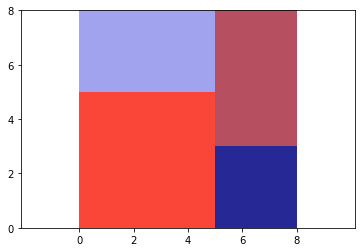

Solution: [[0, 0], [5, 3], [0, 5], [5, 0]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

1 : [[0, 0], [5, 0], [3, 5], [0, 5]] 


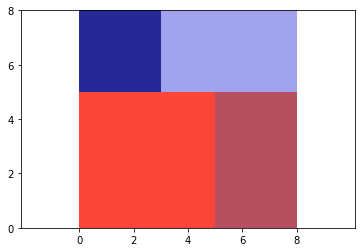

Solution: [[0, 0], [5, 0], [3, 5], [0, 5]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

2 : [[0, 0], [5, 0], [0, 5], [5, 5]] 


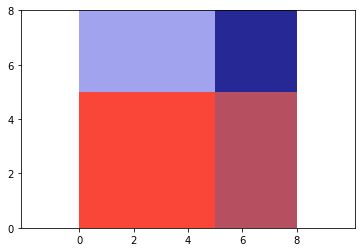

Solution: [[0, 0], [5, 0], [0, 5], [5, 5]]
[w, h]:   [[5, 5], [3, 5], [5, 3], [3, 3]]

Tot: 3



In [16]:
model_name = "pwp_v7-same-dim"
instance_name = "8x8"

path = f"CP/src/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/pwp_v7-same-dim.mzn -t 300000

# Update L for each piece rotated

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})


In [21]:
model_name = "pwp_v8"
instance_name = "8x8"

path = f"CP/src/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -s CP/pwp_v8.mzn -t 300000

# Update L for each piece rotated

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

Error in MiniZinc:
MiniZinc: result of evaluation is undefined: 
  C:\Users\Filippo\Documents\MiniZinc\Present-Wrapping-Problem-Project/CP/pwp_v8.mzn:71:
  in binary '->' operator expression
  in call 'forall'
  in array comprehension expression
    with i = 1
  in call 'com_prec'
  C:\Users\Filippo\Documents\MiniZinc\Present-Wrapping-Problem-Project/CP/pwp_v8.mzn:63:
  in let expression
  C:\Users\Filippo\Documents\MiniZinc\Present-Wrapping-Problem-Project/CP/pwp_v8.mzn:68:
  in binary '/\' operator expression
  C:\Users\Filippo\Documents\MiniZinc\Present-Wrapping-Problem-Project/CP/pwp_v8.mzn:69:
  in call 'cumulative'
  in call 'slice_1d'
  array slice must be contiguous




TypeError: object of type 'NoneType' has no len()

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=16
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=14
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.186045
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=40
mzn-stat: propagators=7
mzn-stat: propagations=30
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end


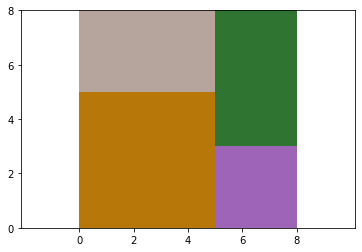

Solution: [[5, 0], [5, 3], [0, 5], [0, 0]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]



|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=68
mzn-stat: flatIntVars=28
mzn-stat: flatBoolConstraints=24
mzn-stat: flatIntConstraints=83
mzn-stat: evaluatedHalfReifiedConstraints=68
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.169001
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=100
mzn-stat: propagators=94
mzn-stat: propagations=241
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end


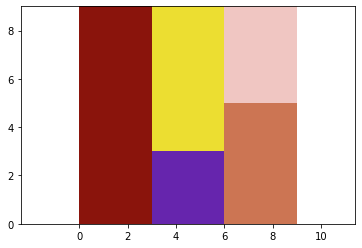

Solution: [[3, 0], [6, 5], [6, 0], [3, 3], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



|| === Instance 10x10 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=74
mzn-stat: flatIntVars=30
mzn-stat: flatBoolConstraints=23
mzn-stat: flatIntConstraints=90
mzn-stat: evaluatedHalfReifiedConstraints=74
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.191319
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=115
mzn-stat: propagators=73
mzn-stat: propagations=251
mzn-stat: nodes=4
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=3
mzn-stat-end


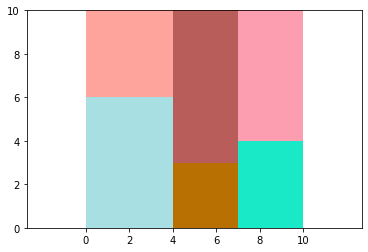

Solution: [[4, 0], [7, 0], [7, 4], [4, 3], [0, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

Pieces: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]



|| === Instance 11x11 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=84
mzn-stat: flatIntVars=30
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=102
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.169051
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=114
mzn-stat: propagators=107
mzn-stat: propagations=1070
mzn-stat: nodes=20
mzn-stat: failures=5
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


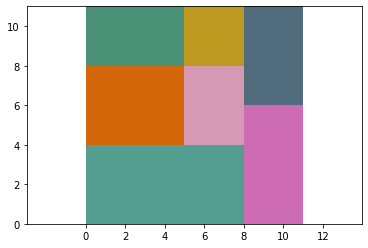

Solution: [[5, 8], [5, 4], [8, 6], [8, 0], [0, 8], [0, 4], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]



|| === Instance 12x12 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=112
mzn-stat: flatIntVars=34
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=132
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.172387
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=146
mzn-stat: propagators=139
mzn-stat: propagations=2397
mzn-stat: nodes=37
mzn-stat: failures=14
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


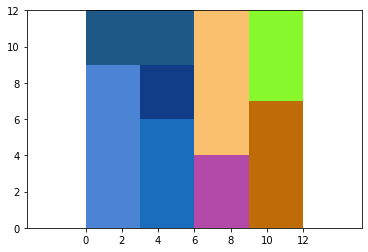

Solution: [[3, 6], [6, 0], [9, 7], [3, 0], [9, 0], [6, 4], [0, 0], [0, 9]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]



|| === Instance 13x13 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=144
mzn-stat: flatIntVars=38
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=166
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.178396
mzn-stat-end
mzn-stat: initTime=0.016
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=182
mzn-stat: propagators=189
mzn-stat: propagations=1089
mzn-stat: nodes=15
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


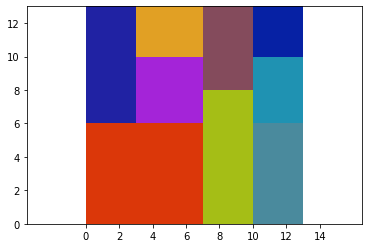

Solution: [[10, 10], [10, 6], [7, 8], [10, 0], [0, 6], [7, 0], [3, 10], [3, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]



|| === Instance 14x14 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=184
mzn-stat: flatIntVars=46
mzn-stat: flatBoolConstraints=57
mzn-stat: flatIntConstraints=206
mzn-stat: evaluatedHalfReifiedConstraints=184
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.180429
mzn-stat-end
mzn-stat: initTime=0.016
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=241
mzn-stat: propagators=197
mzn-stat: propagations=691
mzn-stat: nodes=7
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=6
mzn-stat-end


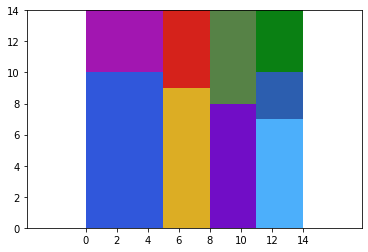

Solution: [[11, 7], [11, 10], [5, 9], [8, 8], [11, 0], [8, 0], [5, 0], [0, 10], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]



|| === Instance 15x15 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=41
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=203
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.178279
mzn-stat-end
mzn-stat: initTime=0.016
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=224
mzn-stat: propagators=214
mzn-stat: propagations=772
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


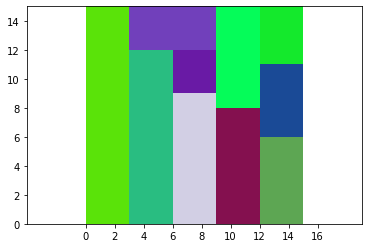

Solution: [[6, 9], [12, 11], [12, 6], [12, 0], [9, 8], [9, 0], [6, 0], [3, 0], [0, 0], [3, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]



|| === Instance 16x16 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=204
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.176968
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=222
mzn-stat: propagators=220
mzn-stat: propagations=811
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


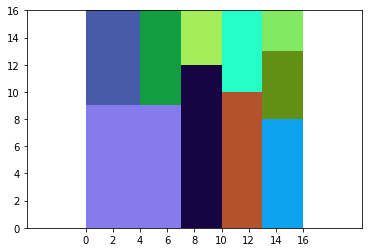

Solution: [[13, 13], [7, 12], [13, 8], [10, 10], [4, 9], [13, 0], [10, 0], [7, 0], [0, 9], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]



|| === Instance 17x17 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=264
mzn-stat: flatIntVars=50
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=292
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.183017
mzn-stat-end
mzn-stat: initTime=0.019
mzn-stat: solveTime=0.004
mzn-stat: solutions=1
mzn-stat: variables=314
mzn-stat: propagators=335
mzn-stat: propagations=26843
mzn-stat: nodes=273
mzn-stat: failures=129
mzn-stat: restarts=0
mzn-stat: peakDepth=20
mzn-stat-end


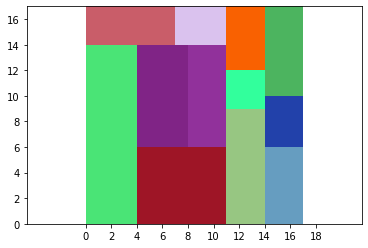

Solution: [[11, 9], [14, 6], [11, 12], [14, 0], [14, 10], [8, 6], [11, 0], [7, 14], [4, 6], [0, 0], [0, 14], [4, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]



|| === Instance 18x18 === ||
%%%mzn-stat: nSolutions=0
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=434
mzn-stat: flatIntVars=70
mzn-stat: flatBoolConstraints=125
mzn-stat: flatIntConstraints=468
mzn-stat: evaluatedHalfReifiedConstraints=434
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.19563
mzn-stat-end
The problem is infeasible
mzn-stat: initTime=0.025
mzn-stat: solveTime=0
mzn-stat: solutions=0
mzn-stat: variables=545
mzn-stat: propagators=0
mzn-stat: propagations=0
mzn-stat: nodes=0
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=0
mzn-stat-end
No solution found in 5min
Pieces: [[3, 3], [3, 4], 

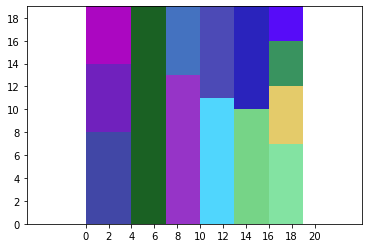

Solution: [[16, 16], [16, 12], [16, 7], [7, 13], [16, 0], [10, 11], [13, 10], [13, 0], [10, 0], [7, 0], [4, 0], [0, 14], [0, 8], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]



|| === Instance 20x20 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=460
mzn-stat: flatIntVars=78
mzn-stat: flatBoolConstraints=139
mzn-stat: flatIntConstraints=494
mzn-stat: evaluatedHalfReifiedConstraints=460
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.191665
mzn-stat-end
mzn-stat: initTime=0.025
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=538
mzn-stat: propagators=583
mzn-stat: propagations=1995
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


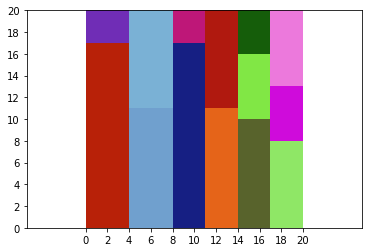

Solution: [[8, 17], [14, 16], [17, 8], [14, 10], [17, 13], [17, 0], [11, 11], [14, 0], [11, 0], [8, 0], [0, 17], [4, 11], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]



|| === Instance 21x21 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=468
mzn-stat: flatIntVars=72
mzn-stat: flatBoolConstraints=139
mzn-stat: flatIntConstraints=500
mzn-stat: evaluatedHalfReifiedConstraints=468
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.193204
mzn-stat-end
mzn-stat: initTime=0.026
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=566
mzn-stat: propagators=464
mzn-stat: propagations=1905
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


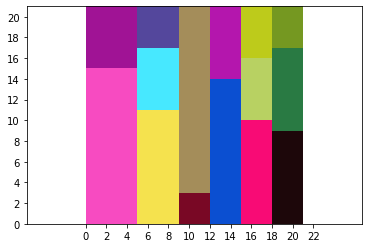

Solution: [[9, 0], [18, 17], [15, 16], [15, 10], [12, 14], [18, 9], [18, 0], [15, 0], [12, 0], [9, 3], [5, 17], [5, 11], [5, 0], [0, 15], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]



|| === Instance 22x22 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=480
mzn-stat: flatIntVars=64
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=515
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.192802
mzn-stat-end
mzn-stat: initTime=0.027
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=548
mzn-stat: propagators=561
mzn-stat: propagations=2244
mzn-stat: nodes=19
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDe

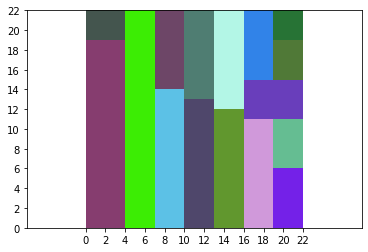

Solution: [[19, 19], [19, 15], [19, 6], [19, 0], [16, 15], [7, 14], [10, 13], [13, 12], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 19], [0, 0], [16, 11]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



|| === Instance 23x23 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=78
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=726
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.201472
mzn-stat-end
mzn-stat: initTime=0.034
mzn-stat: solveTime=13.196
mzn-stat: solutions=1
mzn-stat: variables=762
mzn-stat: propagators=850
mzn-stat: propagations=29586554
mzn-stat: nodes=597585
mzn-stat: failure

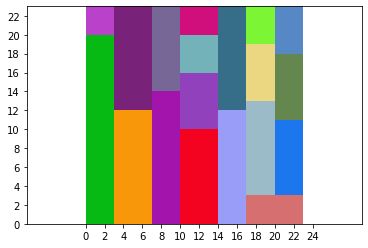

Solution: [[0, 20], [17, 19], [20, 18], [17, 13], [20, 11], [20, 3], [7, 14], [17, 3], [14, 12], [14, 0], [7, 0], [0, 0], [10, 20], [10, 16], [10, 10], [10, 0], [3, 12], [3, 0], [17, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]



|| === Instance 24x24 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=686
mzn-stat: flatIntVars=84
mzn-stat: flatBoolConstraints=205
mzn-stat: flatIntConstraints=722
mzn-stat: evaluatedHalfReifiedConstraints=686
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.251066
mzn-stat-end
mzn-stat: initTime=0.042
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=805
mzn-stat: propagator

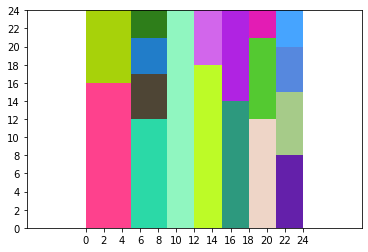

Solution: [[18, 21], [21, 20], [21, 15], [12, 18], [21, 8], [21, 0], [18, 12], [15, 14], [18, 0], [15, 0], [12, 0], [9, 0], [5, 21], [5, 17], [5, 12], [5, 0], [0, 16], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]



|| === Instance 25x25 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=76
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=725
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.250828
mzn-stat-end
mzn-stat: initTime=0.043
mzn-stat: solveTime=0.186
mzn-stat: solutions=1
mzn-stat: variables=764
mzn-stat: propagators=804
mzn-stat: propagations=

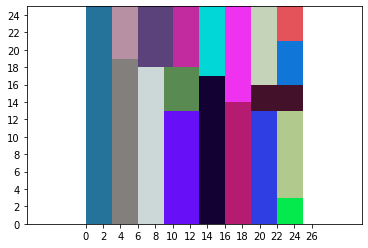

Solution: [[22, 0], [22, 21], [22, 16], [3, 19], [10, 18], [13, 17], [19, 16], [22, 3], [16, 14], [19, 0], [16, 0], [13, 0], [6, 0], [3, 0], [0, 0], [9, 13], [6, 18], [9, 0], [19, 13]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]



|| === Instance 26x26 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1124
mzn-stat: flatIntVars=120
mzn-stat: flatBoolConstraints=331
mzn-stat: flatIntConstraints=1178
mzn-stat: evaluatedHalfReifiedConstraints=1124
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.270498
mzn-stat-end
mzn-stat: initTime=0.082
mzn-stat: solveTime=0.007
mzn-stat: solutions=1
mzn-stat: variables=1244
mzn-stat: propa

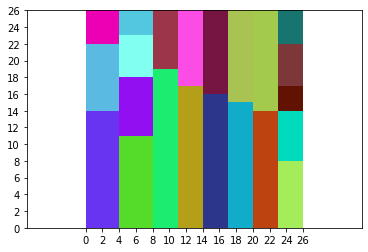

Solution: [[23, 14], [23, 22], [23, 17], [23, 8], [8, 19], [23, 0], [11, 17], [14, 16], [17, 15], [20, 14], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [4, 23], [0, 22], [4, 18], [4, 11], [0, 14], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]



|| === Instance 27x27 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1018
mzn-stat: flatIntVars=115
mzn-stat: flatBoolConstraints=299
mzn-stat: flatIntConstraints=1066
mzn-stat: evaluatedHalfReifiedConstraints=1018
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.263925
mzn-stat-end
mzn-stat: initTime=0.057
mzn-stat: 

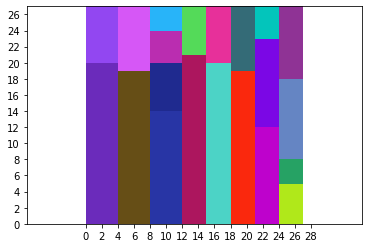

Solution: [[24, 5], [21, 23], [24, 0], [12, 21], [15, 20], [18, 19], [24, 18], [24, 8], [21, 12], [21, 0], [18, 0], [15, 0], [12, 0], [8, 24], [8, 20], [8, 14], [0, 20], [4, 19], [8, 0], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]



|| === Instance 28x28 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1072
mzn-stat: flatIntVars=113
mzn-stat: flatBoolConstraints=308
mzn-stat: flatIntConstraints=1120
mzn-stat: evaluatedHalfReifiedConstraints=1072
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.279577
mzn-stat-end
mzn-stat: initTime=0.061
mzn-stat: solveTime=0.002
mzn-stat: so

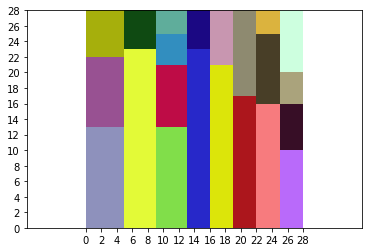

Solution: [[22, 25], [25, 16], [13, 23], [25, 10], [16, 21], [25, 20], [22, 16], [25, 0], [19, 17], [22, 0], [19, 0], [16, 0], [13, 0], [9, 25], [9, 21], [5, 23], [9, 13], [9, 0], [5, 0], [0, 22], [0, 13], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]



|| === Instance 29x29 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1248
mzn-stat: flatIntVars=123
mzn-stat: flatBoolConstraints=351
mzn-stat: flatIntConstraints=1300
mzn-stat: evaluatedHalfReifiedConstraints=1248
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.280594
mzn-stat-end
mzn-stat: initTime=0.068
mzn-stat: s

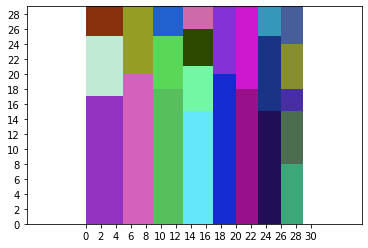

Solution: [[26, 15], [23, 25], [26, 24], [26, 18], [26, 8], [26, 0], [17, 20], [23, 15], [20, 18], [23, 0], [20, 0], [17, 0], [13, 26], [9, 25], [13, 21], [13, 15], [9, 18], [5, 20], [13, 0], [9, 0], [5, 0], [0, 25], [0, 17], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]



|| === Instance 30x30 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=860
mzn-stat: flatIntVars=94
mzn-stat: flatBoolConstraints=255
mzn-stat: flatIntConstraints=900
mzn-stat: evaluatedHalfReifiedConstraints=860
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.257222
m

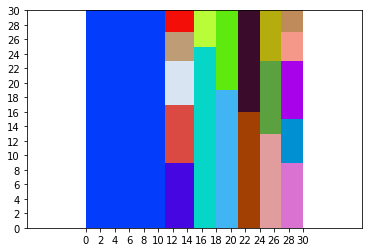

Solution: [[27, 27], [27, 23], [15, 25], [27, 9], [24, 23], [27, 15], [27, 0], [24, 13], [18, 19], [24, 0], [21, 16], [21, 0], [18, 0], [15, 0], [11, 27], [11, 23], [11, 17], [11, 9], [11, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]



|| === Instance 31x31 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=794
mzn-stat: flatIntVars=91
mzn-stat: flatBoolConstraints=237
mzn-stat: flatIntConstraints=832
mzn-stat: evaluatedHalfReifiedConstraints=794
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.264961
mzn-stat-end
mzn-stat: initTime=0.047
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: va

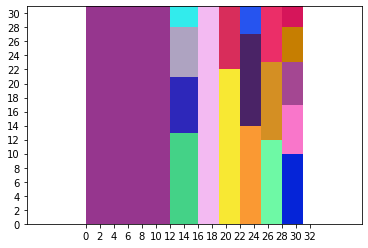

Solution: [[28, 28], [22, 27], [28, 23], [28, 17], [28, 10], [25, 23], [19, 22], [28, 0], [25, 12], [25, 0], [22, 14], [22, 0], [19, 0], [16, 0], [12, 28], [12, 21], [12, 13], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]



|| === Instance 32x32 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1730
mzn-stat: flatIntVars=147
mzn-stat: flatBoolConstraints=514
mzn-stat: flatIntConstraints=1795
mzn-stat: evaluatedHalfReifiedConstraints=1730
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.3122
mzn-stat-end
mzn-stat: initTime=0.086
mzn-stat: solveTime=0.015
mzn-stat: solutions=1
mzn-stat: variables=1877
mzn-sta

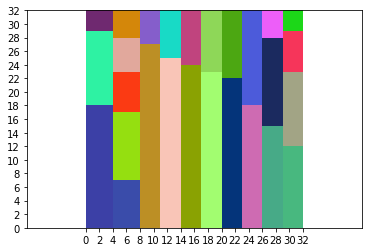

Solution: [[29, 29], [26, 28], [8, 27], [29, 23], [11, 25], [14, 24], [17, 23], [20, 22], [29, 12], [29, 0], [26, 15], [23, 18], [26, 0], [23, 0], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [0, 29], [4, 28], [4, 23], [4, 17], [4, 0], [4, 7], [0, 18], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]



|| === Instance 33x33 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1218
mzn-stat: flatIntVars=120
mzn-stat: flatBoolConstraints=357
mzn-stat: flatIntConstraints=1268
mzn-stat: eva

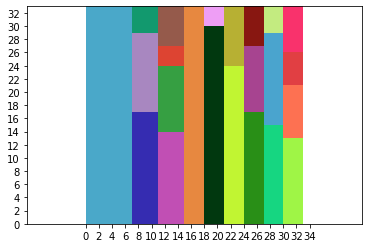

Solution: [[18, 30], [27, 29], [30, 21], [24, 27], [30, 26], [30, 13], [21, 24], [24, 17], [30, 0], [27, 15], [27, 0], [24, 0], [21, 0], [18, 0], [15, 0], [11, 24], [7, 29], [11, 27], [11, 14], [7, 17], [11, 0], [7, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]



|| === Instance 34x34 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1002
mzn-stat: flatIntVars=101
mzn-stat: flatBoolConstraints=302
mzn-stat: flatIntConstraints=1044
mzn-stat: evaluatedHalfReifiedConstraints=1002
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.318976
mzn-stat-en

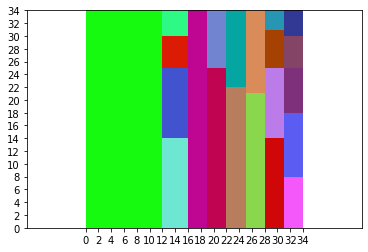

Solution: [[28, 31], [31, 30], [31, 25], [28, 25], [31, 18], [31, 0], [19, 25], [31, 8], [28, 14], [22, 22], [25, 21], [28, 0], [25, 0], [22, 0], [19, 0], [16, 0], [12, 30], [12, 25], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]



|| === Instance 35x35 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1050
mzn-stat: flatIntVars=114
mzn-stat: flatBoolConstraints=294
mzn-stat: flatIntConstraints=1099
mzn-stat: evaluatedHalfReifiedConstraints=1050
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.352281
mzn-stat-end
mzn-stat: initTime=0.058
mzn-stat: solveTime=0.

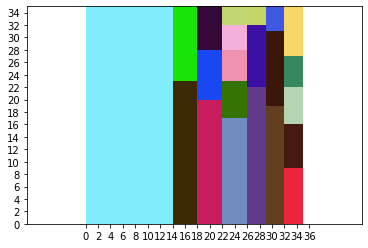

Solution: [[26, 32], [29, 31], [32, 22], [32, 16], [32, 9], [32, 27], [32, 0], [26, 22], [29, 19], [29, 0], [26, 0], [22, 32], [22, 28], [22, 23], [22, 17], [18, 28], [18, 20], [14, 23], [22, 0], [18, 0], [14, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]



|| === Instance 36x36 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1066
mzn-stat: flatIntVars=105
mzn-stat: flatBoolConstraints=309
mzn-stat: flatIntConstraints=1110
mzn-stat: evaluatedHalfReifiedConstraints=1066
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.324203
mzn-stat-end
mzn-stat: initTime=0.061
m

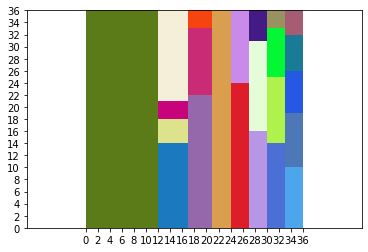

Solution: [[30, 33], [33, 32], [27, 31], [33, 26], [33, 19], [30, 25], [33, 10], [33, 0], [30, 14], [24, 24], [30, 0], [27, 16], [27, 0], [24, 0], [21, 0], [17, 33], [17, 22], [17, 0], [12, 18], [12, 14], [12, 0], [12, 21], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]



|| === Instance 37x37 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1504
mzn-stat: flatIntVars=131
mzn-stat: flatBoolConstraints=416
mzn-stat: flatIntConstraints=1559
mzn-stat: evaluatedHalfReifiedConstraints=1504
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.310855
mzn-s

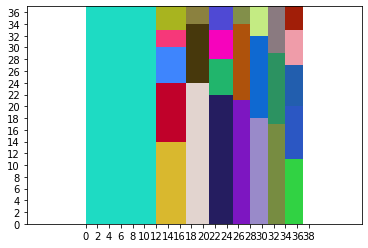

Solution: [[25, 34], [34, 33], [28, 32], [34, 27], [34, 20], [31, 29], [34, 11], [34, 0], [31, 17], [25, 21], [28, 18], [31, 0], [28, 0], [25, 0], [17, 34], [21, 33], [21, 28], [21, 22], [17, 24], [21, 0], [17, 0], [12, 30], [12, 33], [12, 24], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]



|| === Instance 38x38 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=756
mzn-stat: flatIntVars=97
mzn-stat: flatBoolConstraints=207
mzn-stat: flatIntConstraints=799
mzn-st

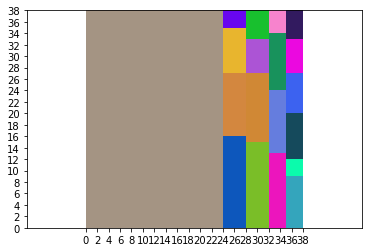

Solution: [[35, 9], [32, 34], [35, 33], [35, 27], [35, 20], [35, 12], [35, 0], [32, 24], [32, 13], [32, 0], [24, 35], [28, 33], [28, 27], [24, 27], [24, 16], [28, 15], [28, 0], [24, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]



|| === Instance 39x39 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1736
mzn-stat: flatIntVars=149
mzn-stat: flatBoolConstraints=462
mzn-stat: flatIntConstraints=1800
mzn-stat: evaluatedHalfReifiedConstraints=1736
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.322201
mzn-stat-end
mzn-stat: initTime=0.09
mzn-stat: solveTime=0.004
mzn-stat: solutions=1
mzn-stat: variables=1895
mzn-sta

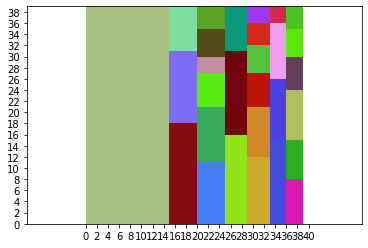

Solution: [[33, 36], [36, 35], [36, 30], [36, 24], [36, 8], [36, 0], [36, 15], [33, 26], [33, 15], [33, 0], [29, 36], [29, 32], [29, 27], [29, 21], [25, 31], [29, 12], [29, 0], [25, 16], [25, 0], [20, 27], [20, 35], [20, 30], [20, 21], [15, 31], [20, 11], [20, 0], [15, 18], [15, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]



|| === Instance 40x40 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=706
mzn-stat: flatIntVars=86
mzn-stat: flatBoolConstra

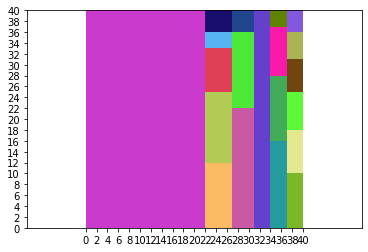

Solution: [[34, 37], [37, 36], [37, 31], [37, 25], [37, 18], [37, 10], [34, 28], [37, 0], [34, 16], [34, 0], [31, 0], [27, 36], [27, 22], [27, 0], [22, 33], [22, 36], [22, 25], [22, 0], [22, 12], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]





In [13]:
starting_instance = 8
ending_instance = 40

for i in range(starting_instance, ending_instance+1):
    path = f"CP/src/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    # execute the model to get the first solution in 5 min max
    sol = %minizinc -s CP/pwp_v8.mzn -t 300000
    
    if sol is not None:
        graph_solution(pr_w, pr_h, n_pieces, L, sol['q'])
    else:
        print("No solution found in 5min")
        
    print(f"Pieces: {L}")
    print("\n\n")

In [217]:
instance = "20x20"
path = f"CP/src/{instance}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)

unordered_pieces = list(L)
decr_order = True

#L = order_pieces(unordered_pieces, reverse=decr_order)
pr_w, pr_h, n_pieces, L

(20,
 20,
 14,
 [[3, 3],
  [3, 4],
  [3, 5],
  [3, 6],
  [3, 7],
  [3, 8],
  [3, 9],
  [3, 10],
  [3, 11],
  [3, 17],
  [4, 3],
  [4, 9],
  [4, 11],
  [4, 17]])

In [218]:
q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
domain = [And(0<=q[i][0],q[i][0]<pr_w,0<=q[i][1],q[i][1]< pr_h) for i in range(n_pieces)]
in_strip = [And(pr_w>=q[i][0]+L[i][0],pr_h>=q[i][1]+L[i][1]) for i in range(n_pieces)]
l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

"""
l = [And(l_i_j[0]==(q[0][0]+L[0][0]<=q[1][0]), l_i_j[1]==(q[0][0]+L[0][0]<=q[2][0]), l_i_j[2]==(q[0][0]+L[0][0]<=q[3][0]),
         l_i_j[3]==(q[1][0]+L[1][0]<=q[0][0]), l_i_j[4]==(q[1][0]+L[1][0]<=q[2][0]), l_i_j[5]==(q[1][0]+L[1][0]<=q[3][0]),
         l_i_j[6]==(q[2][0]+L[2][0]<=q[0][0]), l_i_j[7]==(q[2][0]+L[2][0]<=q[1][0]), l_i_j[8]==(q[2][0]+L[2][0]<=q[3][0]),
         l_i_j[9]==(q[3][0]+L[3][0]<=q[0][0]), l_i_j[10]==(q[3][0]+L[3][0]<=q[1][0]), l_i_j[11]==(q[3][0]+L[3][0]<=q[2][0])
        )]
"""
l_prova = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+L[i][0]<=q[j][0])
            
            ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

#prova = [i*(n_pieces-1)+(j-1 if j>i else j)  for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]] #And(e>=0, e<=pr_w-L[i][0])
"""
u = [And(u_i_j[0]==(q[0][1]+L[0][1]<=q[1][1]), u_i_j[1]==(q[0][1]+L[0][1]<=q[2][1]), u_i_j[2]==(q[0][1]+L[0][1]<=q[3][1]),
         u_i_j[3]==(q[1][1]+L[1][1]<=q[0][1]), u_i_j[4]==(q[1][1]+L[1][1]<=q[2][1]), u_i_j[5]==(q[1][1]+L[1][1]<=q[3][1]),
         u_i_j[6]==(q[2][1]+L[2][1]<=q[0][1]), u_i_j[7]==(q[2][1]+L[2][1]<=q[1][1]), u_i_j[8]==(q[2][1]+L[2][1]<=q[3][1]),
         u_i_j[9]==(q[3][1]+L[3][1]<=q[0][1]), u_i_j[10]==(q[3][1]+L[3][1]<=q[1][1]), u_i_j[11]==(q[3][1]+L[3][1]<=q[2][1])
        )]
"""
u_prova = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
            
            ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

e = Int('e')
f = Int('f')

max_e = max([pr_w-L[i][0] for i in range(n_pieces)])
max_f = max([pr_h-L[i][1] for i in range(n_pieces)])

e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]


px = [ Bool("px_%s_%s" % (i, j)) for j in range(max_e) for i in range(n_pieces) ]
py = [ Bool("py_%s_%s" % (i, j)) for j in range(max_f) for i in range(n_pieces) ]

px_t = [And(px[(j*(n_pieces)+i)]==(q[i][0]<=j),
        ) for i in range(n_pieces) for j in range(max_e)]
py_t = [And(py[(j*(n_pieces)+i)]==(q[i][1]<=j),
        ) for j in range(max_f) for i in range(n_pieces)]

#;Order Encoding

o_e_px = [ And(
    Or(
        Not(px[(j*(n_pieces)+i)]), px[((j+1)*(n_pieces)+i)]
     )) for i in range(n_pieces) for j in range(max_e-1) ]
o_e_py = [ And(
    Or(
        Not(py[(j*(n_pieces)+i)]), py[((j+1)*(n_pieces)+i)]
     )) for i in range(n_pieces) for j in range(max_f-1) ]
#A = Array('A', IntSort(), IntSort())
#type(A[e])
index = ["%s-%s"%(i, j) for i in range(n_pieces) for j in range(i+1,n_pieces)] 
#['0-1', '0-2', '0-3', '1-2', '1-3', '2-3']
#['0',   '1',   '2',   '4',   '5',   '8']  i*3+(j-1)
#['3',   '6',   '9',   '7',   '10',   '11'] i+j*3

#;Non-Overlapping 1
n_o_1 = [ And(
    Or(
        l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
     )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

In [211]:
px

[px_0_0,
 px_1_0,
 px_2_0,
 px_3_0,
 px_0_1,
 px_1_1,
 px_2_1,
 px_3_1,
 px_0_2,
 px_1_2,
 px_2_2,
 px_3_2]

In [212]:
max_e, max_f

(3, 1)

In [112]:
def z3max(x,y):
    return If(x > y, x, y)

def z3min(x,y):
    return If(x < y, x, y)

bl_corners= [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
domain = [And(0<=bl_corners[i][0],bl_corners[i][0]<pr_w,0<=bl_corners[i][1],bl_corners[i][1]< pr_h) for i in range(n_pieces)]
overflow = [And(bl_corners[i][0]+L[i][0]<=pr_w,bl_corners[i][1]+L[i][1]<=pr_h) for i in range(n_pieces)]
pp(bl_corners)
intersection = [ And(
    Or(
        z3max(bl_corners[i][0],bl_corners[j][0])>=z3min(bl_corners[i][0]+L[i][0],bl_corners[j][0]+L[j][0]),
        z3max(bl_corners[i][1],bl_corners[j][1])>=z3min(bl_corners[i][1]+L[i][1],bl_corners[j][1]+L[j][1])
     )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

[[c_0_0, c_0_1],
 [c_1_0, c_1_1],
 [c_2_0, c_2_1],
 [c_3_0, c_3_1]]


coords:   [[17, 17], [14, 0], [0, 7], [14, 14], [0, 0], [0, 12], [7, 0], [14, 4], [7, 9], [17, 0], [3, 17], [10, 0], [10, 9], [3, 0]]


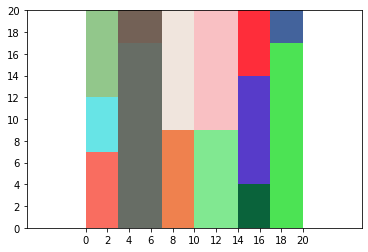

Solution: [[17, 17], [14, 0], [0, 7], [14, 14], [0, 0], [0, 12], [7, 0], [14, 4], [7, 9], [17, 0], [3, 17], [10, 0], [10, 9], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

Tot: 1

Wall time: 279 ms


[c_8_0 = 7,
 c_7_1 = 4,
 c_4_0 = 0,
 c_7_0 = 14,
 e = 0,
 c_13_0 = 3,
 c_1_0 = 14,
 f = 0,
 c_9_0 = 17,
 c_12_1 = 9,
 c_0_1 = 17,
 c_5_1 = 12,
 c_6_1 = 0,
 c_4_1 = 0,
 c_10_1 = 17,
 c_0_0 = 17,
 c_1_1 = 0,
 c_3_1 = 14,
 c_11_0 = 10,
 c_3_0 = 14,
 c_13_1 = 0,
 c_11_1 = 0,
 c_2_1 = 7,
 c_8_1 = 9,
 c_12_0 = 10,
 c_2_0 = 0,
 c_5_0 = 0,
 c_6_0 = 7,
 c_9_1 = 0,
 c_10_0 = 3,
 py_13_16 = True,
 py_13_15 = True,
 py_13_14 = True,
 py_13_13 = True,
 py_13_12 = True,
 py_13_11 = True,
 py_13_10 = True,
 py_13_9 = True,
 py_13_8 = True,
 py_13_7 = True,
 py_13_6 = True,
 py_13_5 = True,
 py_13_4 = True,
 py_12_16 = True,
 py_12_15 = True,
 py_12_14 = True,
 py_12_13 = True,
 py_12_12 = True,
 py_12_11 = True,
 py_12_10 = True,
 py_11_16 = True,
 py_11_15 = True,
 py_11_14 = True,
 py_11_13 = True,
 py_11_12 = True,
 py_9_16 = True,
 py_9_15 = True,
 py_9_14 = True,
 py_9_13 = True,
 py_9_12 = True,
 py_9_11 = True,
 py_9_10 = True,
 py_9_9 = True,
 py_9_8 = True,
 py_9_7 = True,
 py_9_6 = True,
 py_9_5 = True,
 py_9_4 = True,
 py_8_16 = True,
 py_8_15 = True,
 py_8_14 = True,
 py_8_13 = True,
 py_8_12 = True,
 py_8_11 = True,
 py_8_10 = True,
 py_7_16 = True,
 py_7_15 = True,
 py_7_14 = True,
 py_7_13 = True,
 py_7_12 = True,
 py_7_11 = True,
 py_6_16 = True,
 py_6_15 = True,
 py_6_14 = True,
 py_6_13 = True,
 py_6_12 = True,
 py_5_16 = True,
 py_5_15 = True,
 py_5_14 = True,
 py_5_13 = True,
 py_4_16 = True,
 py_4_15 = True,
 py_4_14 = True,
 py_3_16 = True,
 py_3_15 = True,
 py_2_16 = True,
 py_10_16 = False,
 py_1_16 = True,
 py_0_16 = False,
 py_10_15 = False,
 py_2_15 = True,
 py_1_15 = True,
 py_0_15 = False,
 py_10_14 = False,
 py_3_14 = True,
 py_2_14 = True,
 py_1_14 = True,
 py_0_14 = False,
 py_10_13 = False,
 py_4_13 = True,
 py_3_13 = False,
 py_2_13 = True,
 py_1_13 = True,
 py_0_13 = False,
 py_10_12 = False,
 py_5_12 = True,
 py_4_12 = True,
 py_3_12 = False,
 py_2_12 = True,
 py_1_12 = True,
 py_0_12 = False,
 py_11_11 = True,
 py_10_11 = False,
 py_6_11 = True,
 py_5_11 = False,
 py_4_11 = True,
 py_3_11 = False,
 py_2_11 = True,
 py_1_11 = True,
 ...]

In [219]:
%%time
s = Solver()
s.add(domain + in_strip + l_prova + u_prova + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1) #overflow + intersection)
s.check()
sol = s.model()
solution=[[sol[q[i][0]].as_long(), sol[q[i][1]].as_long()] for i in range(n_pieces)]
len(solution)
#{'q': [[0, 0], [5, 0], [3, 5], [0, 5]]}
prova = {'q': solution}
print_solutions(prova, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

sol